In [ ]:
!unzip  /content/t -d extracted_folder

Archive:  /content/t.zip
   creating: extracted_folder/dataset_combined/
   creating: extracted_folder/dataset_combined/train/
   creating: extracted_folder/dataset_combined/train/no_pores/
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029306.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029307.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029308.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029309.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029310.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029311.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029312.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029313.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029314.jpg  
  inflating: extracted_folder/dataset_combined/train/no_pores/ISIC_0029315.jpg  


In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    f1_score
)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator
)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)


ModuleNotFoundError: No module named 'evaluate'

In [ ]:
import kagglehub
from pathlib import Path
from tqdm import tqdm
import os
import pandas as pd

path = '/content/extracted_folder/dataset_combined'
file_names = []
labels = []

supported_extensions = ('.jpg', '.jpeg', '.png')

for file in tqdm(sorted(Path(path).rglob('*/*/*'))):
    if file.suffix.lower() in supported_extensions:
        file_names.append(str(file))
        label = file.parent.name
        labels.append(label)

print(f"Total images: {len(file_names)}, Total labels: {len(labels)}, Unique labels: {len(set(labels))}")

if len(file_names) != len(labels):
    print("Warning: The number of images does not match the number of labels!")

df = pd.DataFrame({"image": file_names, "label": labels})
print(df.head())

df.to_csv("skin_types_dataset.csv", index=False)
print("Dataframe saved to 'skin_types_dataset.csv'")


100%|██████████| 1146/1146 [00:00<00:00, 194610.00it/s]

Total images: 1146, Total labels: 1146, Unique labels: 2
                                               image     label
0  /content/extracted_folder/dataset_combined/tra...  no_pores
1  /content/extracted_folder/dataset_combined/tra...  no_pores
2  /content/extracted_folder/dataset_combined/tra...  no_pores
3  /content/extracted_folder/dataset_combined/tra...  no_pores
4  /content/extracted_folder/dataset_combined/tra...  no_pores
Dataframe saved to 'skin_types_dataset.csv'


In [ ]:
df['label'].unique()

array(['no_pores', 'pores'], dtype=object)

In [ ]:
df['label'].value_counts().head()

,count
label,
no_pores,614
pores,532


In [ ]:

from imblearn.over_sampling import RandomOverSampler
import gc
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
del y_resampled
gc.collect()

print(df.shape)

(1228, 2)


In [ ]:
df['label'].value_counts().head()

,count
label,
no_pores,614
pores,614


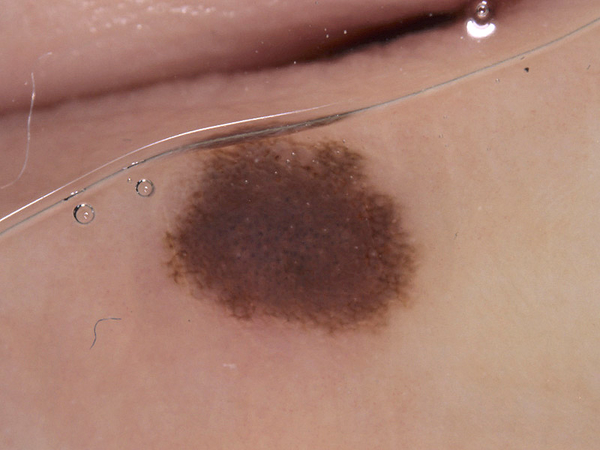

In [ ]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())
dataset[0]['image']

In [ ]:
labels_subset = list(df['label'])[:5]
print(labels_subset)

['no_pores', 'no_pores', 'no_pores', 'no_pores', 'no_pores']


In [ ]:
labels_list = sorted(list(set(df['label'])))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label


print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'no_pores', 1: 'pores'} 

Mapping of Labels to IDs: {'no_pores': 0, 'pores': 1}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

train_data = dataset['train']

test_data = dataset['test']

Map:   0%|          | 0/1228 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1228 [00:00<?, ? examples/s]

In [ ]:

model_str = "dima806/skin_types_image_detection"

processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size["height"]
print("Size: ", size)
normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose(
    [
        Resize((size, size)),
        RandomRotation(90),
        RandomAdjustSharpness(2),
        RandomHorizontalFlip(0.5),
        ToTensor(),
        normalize
    ]
)

_val_transforms = Compose(
    [
        Resize((size, size)),
        ToTensor(),
        normalize
    ]
)
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

Size:  224


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])

    labels = torch.tensor([example['label'] for example in examples])

    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
from transformers import ViTForImageClassification

# Load the pre-trained model with mismatched sizes allowed
model = ViTForImageClassification.from_pretrained(
    model_str,
    num_labels=len(labels_list),  # Ensure this matches the new task's labels
    ignore_mismatched_sizes=True  # This allows the model to load with a different classifier size
)

# Update the model's configuration for label mapping
model.config.id2label = id2label
model.config.label2id = label2id

# Print the number of trainable parameters
print(f"Trainable parameters: {model.num_parameters(only_trainable=True) / 1e6:.2f}M")


config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at dima806/skin_types_image_detection and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 85.80M


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)

    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

In [ ]:
metric_name = "accuracy"

model_name = "Pores_Classification"

num_train_epochs = 5

args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=5e-7,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=32,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
   load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
trainer.evaluate()

{'eval_loss': 0.6415497660636902,
 'eval_model_preparation_time': 0.0086,
 'eval_accuracy': 0.8008130081300813,
 'eval_runtime': 383.7626,
 'eval_samples_per_second': 1.282,
 'eval_steps_per_second': 0.042}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.640190,0.008600,0.804878


In [ ]:
outputs = trainer.predict(test_data)

In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 250:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print()
print("Classification report:")
print()
try:
    print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))
except:
    pass

In [ ]:
import os
import cv2
import csv

# Function to calculate pore sizes based on connected components
def calculate_pore_sizes(image):
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image)
    # Skip the background label (label 0)
    pore_sizes = stats[1:, cv2.CC_STAT_AREA]  # Areas of connected components
    return pore_sizes

# Main function to process a single image and calculate pore sizes
def process_image(image_path):
    # Load the grayscale image
    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Example preprocessing
    _, binary_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)

    # Calculate pore sizes
    pore_sizes = calculate_pore_sizes(binary_image)
    return pore_sizes

# Directory containing images
directory_path = "/content/extracted_folder/dataset_combined/train/pores"

# CSV file to save results
output_csv = "/content/pore_sizes.csv"

# Process all images and save results to CSV
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "Pore Sizes (Pixels)"])  # Header row

    for filename in os.listdir(directory_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(directory_path, filename)
            print(f"Processing: {image_path}")
            pore_sizes = process_image(image_path)

            # Write results to CSV
            writer.writerow([filename, list(pore_sizes)])


Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_636.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_2415.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_5864.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_6673.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_1416.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_5994.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_3050.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_1276.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_2847.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_458.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/pores_0_2737.jpeg
Processing: /content/extracted_folder/dataset_combined/train/pores/

In [ ]:
import pandas as pd
df = pd.read_csv('/content/pore_sizes.csv')

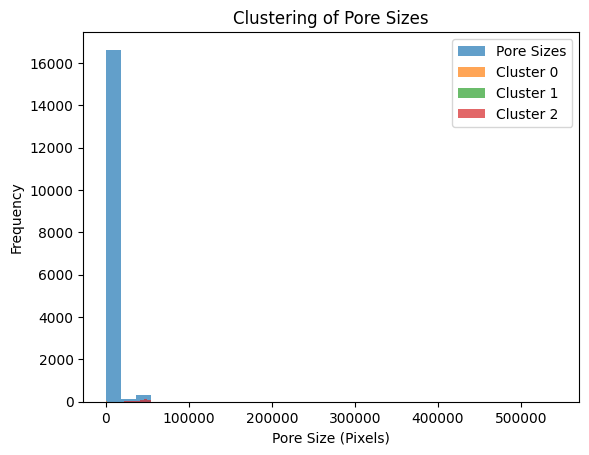

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the CSV file
csv_path = "/content/pore_sizes.csv"  # Update to your file's path
data = pd.read_csv(csv_path)

# Prepare to store image names and pore sizes
image_names = []
pore_sizes = []

# Flatten the pore sizes and associate them with their image names
for _, row in data.iterrows():
    sizes_list = eval(row["Pore Sizes (Pixels)"])  # Convert string back to list
    pore_sizes.extend(sizes_list)
    image_names.extend([row["Image"]] * len(sizes_list))  # Associate each pore size with its image name

# Convert to NumPy array for clustering
pore_sizes = np.array(pore_sizes).reshape(-1, 1)

# Normalize the data (optional but recommended for KMeans)
scaler = StandardScaler()
pore_sizes_scaled = scaler.fit_transform(pore_sizes)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pore_sizes_scaled)

# Get cluster labels
labels = kmeans.labels_

# Add cluster labels, pore sizes, and image names to a DataFrame
clustered_data = pd.DataFrame({
    "Image": image_names,
    "Pore Size": pore_sizes.flatten(),
    "Cluster": labels
})

# Save clustering results to a CSV file
clustered_data.to_csv("/content/clustered_pore_sizes_with_images.csv", index=False)

# Visualize the clusters (1D histogram)
plt.hist(pore_sizes, bins=30, alpha=0.7, label="Pore Sizes")
for cluster in range(3):  # Assuming 3 clusters
    cluster_points = pore_sizes[labels == cluster]
    plt.hist(cluster_points, bins=30, alpha=0.7, label=f"Cluster {cluster}")
plt.xlabel("Pore Size (Pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.title("Clustering of Pore Sizes")
plt.show()


In [ ]:
clustered_data.head()

,Image,Pore Size,Cluster
0,pores_0_636.jpeg,14,0
1,pores_0_636.jpeg,49842,2
2,pores_0_636.jpeg,2,0
3,pores_0_2415.jpeg,45134,2
4,pores_0_2415.jpeg,3,0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the clustered data
clustered_csv = "/content/clustered_pore_sizes_with_images.csv"  # Update to your file path
data = pd.read_csv(clustered_csv)

# Features (Pore Size) and Labels (Clusters)
X = data["Pore Size"].values.reshape(-1, 1)  # Feature: Pore sizes
y = data["Cluster"].values  # Target: Cluster labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classification model (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model (optional)
import joblib
joblib.dump(model, "/content/pore_size_model.pkl")


Confusion Matrix:
[[4988    0    0]
 [   0    2    2]
 [   1    0  125]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4988
           1       1.00      0.50      0.67         4
           2       0.98      0.99      0.99       126

    accuracy                           1.00      5118
   macro avg       0.99      0.83      0.88      5118
weighted avg       1.00      1.00      1.00      5118



['/content/pore_size_model.pkl']

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.color import rgba2rgb

# Function to calculate statistical features from pore sizes
def calculate_statistical_features(pore_sizes):
    mean = np.mean(pore_sizes)
    median = np.median(pore_sizes)
    variance = np.var(pore_sizes)
    skewness = skew(pore_sizes)
    return mean, median, variance, skewness

# Function to extract GLCM-based texture features from an image
def calculate_texture_features(image_path):
    image = imread(image_path)

    # Check if the image has an alpha channel and convert to RGB if necessary
    if image.shape[-1] == 4:
        image = rgba2rgb(image)

    if len(image.shape) == 3:  # Convert to grayscale if needed
        image = rgb2gray(image)
    image = (image * 255).astype(np.uint8)  # Scale to 8-bit

    glcm = graycomatrix(image, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return contrast, correlation, energy, homogeneity

# Directory containing images
directory_path = "/content/extracted_folder/dataset_combined/train/pores"

# Dataframe to store features
data = []

# Process each image
for filename in os.listdir(directory_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join(directory_path, filename)

        # Example pore sizes (load actual data from previous clustering results)
        pore_sizes = process_image(image_path)  # Replace with your existing pore size calculation logic

        # Statistical features
        mean, median, variance, skewness = calculate_statistical_features(pore_sizes)

        # Texture features
        contrast, correlation, energy, homogeneity = calculate_texture_features(image_path)

        # Append to the dataset
        data.append({
            "Image": filename,
            "Mean": mean,
            "Median": median,
            "Variance": variance,
            "Skewness": skewness,
            "Contrast": contrast,
            "Correlation": correlation,
            "Energy": energy,
            "Homogeneity": homogeneity
        })

# Convert to a DataFrame
features_df = pd.DataFrame(data)
print(features_df.head())

# Save the features to a CSV for future use
features_df.to_csv("/content/pore_features.csv", index=False)


               Image          Mean   Median      Variance   Skewness  \
0   pores_0_636.jpeg  16619.333333     14.0  5.518728e+08   0.707107   
1  pores_0_2415.jpeg  22568.500000  22568.5  5.092018e+08   0.000000   
2  pores_0_5864.jpeg    226.584000      4.0  5.028991e+06  11.019894   
3  pores_0_6673.jpeg   4857.222222      3.0  1.842985e+08   2.474383   
4  pores_0_1416.jpeg  24913.500000  24913.5  6.206327e+08   0.000000   

    Contrast  Correlation    Energy  Homogeneity  
0  18.501942     0.989857  0.037387     0.340613  
1   8.429412     0.992476  0.078666     0.500055  
2  36.698070     0.958848  0.027569     0.222576  
3  22.239610     0.988405  0.038028     0.322574  
4  68.264254     0.855854  0.026583     0.148127  


In [ ]:
features_df.head()

,Image,Mean,Median,Variance,Skewness,Contrast,Correlation,Energy,Homogeneity
0,pores_0_636.jpeg,16619.333333,14.0,5.518728e+08,0.707107,18.501942,0.989857,0.037387,0.340613
1,pores_0_2415.jpeg,22568.500000,22568.5,5.092018e+08,0.000000,8.429412,0.992476,0.078666,0.500055
2,pores_0_5864.jpeg,226.584000,4.0,5.028991e+06,11.019894,36.698070,0.958848,0.027569,0.222576
3,pores_0_6673.jpeg,4857.222222,3.0,1.842985e+08,2.474383,22.239610,0.988405,0.038028,0.322574
4,pores_0_1416.jpeg,24913.500000,24913.5,6.206327e+08,0.000000,68.264254,0.855854,0.026583,0.148127


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset with features and target labels
features_df = pd.read_csv("/content/pore_features.csv")  # Features from the previous step
target_df = pd.read_csv("/content/clustered_pore_sizes_with_images.csv")  # Clustered pore sizes

# Combine features with cluster labels
merged_data = features_df.merge(target_df, on="Image")
X = merged_data.drop(columns=["Image", "Cluster"])  # Drop image and target columns
y = merged_data["Cluster"]  # Target: Cluster labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest with GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_

KeyboardInterrupt: 

In [ ]:
# Check cluster distribution
import pandas as pd

data = pd.read_csv("/content/clustered_pore_sizes_with_images.csv")  # Adjust path
print(data["Cluster"].value_counts())


Cluster
0    16647
2      405
1        7
Name: count, dtype: int64


In [ ]:
!pip install imbalanced-learn


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter

In [ ]:
# Load features and labels
features_df = pd.read_csv("/content/pore_features.csv")
clusters_df = pd.read_csv("/content/clustered_pore_sizes_with_images.csv")

# Merge features and clusters on "Image"
data = features_df.merge(clusters_df, on="Image", how="inner")

# Extract features (X) and labels (y)
X = data.drop(columns=["Image", "Cluster"])
y = data["Cluster"]

# Check class distribution
print("Original cluster distribution:", Counter(y))


Original cluster distribution: Counter({0: 16647, 2: 405, 1: 7})


In [ ]:
import pandas as pd
print(pd.DataFrame(X).isnull().sum())


Mean           0
Median         0
Variance       0
Skewness       0
Contrast       0
Correlation    0
Energy         0
Homogeneity    0
Pore Size      0
dtype: int64


In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

# Assuming X is a DataFrame
imputer = SimpleImputer(strategy='mean')  # Use 'median' if preferred
X['Skewness'] = imputer.fit_transform(X[['Skewness']])


In [ ]:
# Define SMOTE and undersampling strategy
smote = SMOTE(sampling_strategy={1: 406, 2: 406}, k_neighbors=min(len(y[y == 1]) - 1, len(y[y == 2]) - 1, 5))  # Oversample minority clusters with adjusted k_neighbors
undersampler = RandomUnderSampler(sampling_strategy={0: 5000})  # Undersample majority cluster

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)



# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

# Check new class distribution
print("Resampled cluster distribution:", Counter(y_resampled))


Resampled cluster distribution: Counter({0: 5000, 1: 406, 2: 406})


In [ ]:
# Apply SMOTE after handling missing values
X_resampled, y_resampled = smote.fit_resample(X, y)

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

# Check the new class distribution
from collections import Counter
print("Resampled cluster distribution:", Counter(y_resampled))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees in the forest
    "max_depth": [None, 10, 20, 30],  # Maximum depth of the tree
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4]  # Minimum samples required in a leaf node
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)  # n_jobs=-1 to use all CPUs
grid_search.fit(X_train, y_train)

# Extract the best model
best_model = grid_search.best_estimator_
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best parameters found by GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Confusion Matrix:
[[1530    0    0]
 [   0   97    2]
 [   0    0  115]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1530
           1       1.00      0.98      0.99        99
           2       0.98      1.00      0.99       115

    accuracy                           1.00      1744
   macro avg       0.99      0.99      0.99      1744
weighted avg       1.00      1.00      1.00      1744

